# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()] );
    
    dataset_ = datasets.ImageFolder(data_dir, transform);
    data_loader = torch.utils.data.DataLoader(dataset=dataset_, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=8);
    
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

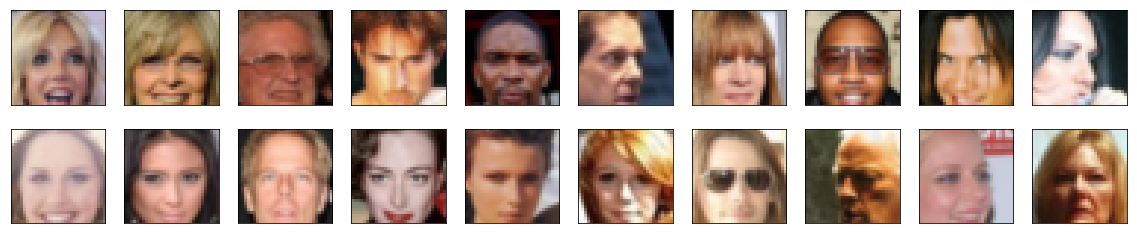

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range;
    x = x * (max_ - min_) + min_;
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8039)
Max:  tensor(0.7882)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    for t in m.modules() :
        if isinstance(t, nn.Conv2d) or isinstance(t, nn.ConvTranspose2d) :
            nn.init.normal_(t.weight, 0, 0.02);
        elif isinstance(t, nn.Linear) :
            nn.init.normal_(t.weight, 0, 0.02);
            nn.init.constant_(t.bias, 0);
        elif isinstance(t, nn.BatchNorm2d) :
            nn.init.constant_(t.weight, 1);
            nn.init.constant_(t.bias, 0);
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [18]:
# setup the available device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [19]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [20]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr, beta1, beta2 = 0.0005, 0.3, 0.999;

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2]);
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2]);

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [21]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu :
                real_images = real_images.cuda();
            
            # train D with real images
            D_real = D(real_images);
            d_real_loss = real_loss(D_real);
            
            # train D with fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size));
            z = torch.from_numpy(z).float();
            if train_on_gpu :
                z = z.cuda();
                
            fake_images = G(z);
            D_fake = D(fake_images);
            d_fake_loss = fake_loss(D_fake);
            
            # combine real and fake loss for D and backprop
            d_loss = d_real_loss + d_fake_loss;
            d_optimizer.zero_grad();            
            d_loss.backward();
            d_optimizer.step();

            # 2. Train the generator with an adversarial loss
            z = np.random.uniform(-1, 1, size=(batch_size, z_size));
            z = torch.from_numpy(z).float();
            if train_on_gpu :
                z = z.cuda();
                
            fake_images = G(z);
            
            # compute D losses on fake images with flipped labels !
            D_fake = D(fake_images);
            g_loss = real_loss(D_fake);
            g_optimizer.zero_grad();            
            g_loss.backward();
            g_optimizer.step();
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [22]:
# set number of epochs 
n_epochs = 40


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   40] | d_loss: 1.3358 | g_loss: 1.5378
Epoch [    1/   40] | d_loss: 0.5078 | g_loss: 2.5586
Epoch [    1/   40] | d_loss: 1.4042 | g_loss: 0.9546
Epoch [    1/   40] | d_loss: 1.0241 | g_loss: 0.6643
Epoch [    1/   40] | d_loss: 1.1407 | g_loss: 0.8839
Epoch [    1/   40] | d_loss: 1.1513 | g_loss: 0.7125
Epoch [    1/   40] | d_loss: 1.2254 | g_loss: 1.4182
Epoch [    1/   40] | d_loss: 1.3703 | g_loss: 1.0063
Epoch [    1/   40] | d_loss: 1.0203 | g_loss: 1.8187
Epoch [    1/   40] | d_loss: 1.2502 | g_loss: 0.8863
Epoch [    1/   40] | d_loss: 1.1006 | g_loss: 1.4275
Epoch [    1/   40] | d_loss: 1.0719 | g_loss: 1.2547
Epoch [    1/   40] | d_loss: 1.3959 | g_loss: 0.8776
Epoch [    1/   40] | d_loss: 1.0854 | g_loss: 0.8535
Epoch [    1/   40] | d_loss: 1.0146 | g_loss: 0.9760
Epoch [    1/   40] | d_loss: 1.4158 | g_loss: 0.8348
Epoch [    1/   40] | d_loss: 1.2511 | g_loss: 1.3600
Epoch [    1/   40] | d_loss: 1.1793 | g_loss: 0.6365
Epoch [    1/   40] | d_loss

Epoch [    3/   40] | d_loss: 1.0445 | g_loss: 1.2812
Epoch [    3/   40] | d_loss: 1.0067 | g_loss: 1.0680
Epoch [    3/   40] | d_loss: 1.0136 | g_loss: 1.6722
Epoch [    3/   40] | d_loss: 0.9804 | g_loss: 0.9237
Epoch [    3/   40] | d_loss: 0.9400 | g_loss: 1.0418
Epoch [    3/   40] | d_loss: 1.1732 | g_loss: 0.8118
Epoch [    3/   40] | d_loss: 1.0461 | g_loss: 1.6353
Epoch [    3/   40] | d_loss: 1.2769 | g_loss: 0.8376
Epoch [    3/   40] | d_loss: 0.8547 | g_loss: 0.9003
Epoch [    3/   40] | d_loss: 0.9647 | g_loss: 2.1234
Epoch [    3/   40] | d_loss: 1.1553 | g_loss: 1.3385
Epoch [    3/   40] | d_loss: 0.9996 | g_loss: 1.5753
Epoch [    3/   40] | d_loss: 1.1539 | g_loss: 1.4132
Epoch [    3/   40] | d_loss: 1.2270 | g_loss: 2.1858
Epoch [    3/   40] | d_loss: 1.5851 | g_loss: 0.7872
Epoch [    3/   40] | d_loss: 1.1296 | g_loss: 0.7783
Epoch [    3/   40] | d_loss: 1.1193 | g_loss: 1.7197
Epoch [    3/   40] | d_loss: 0.8348 | g_loss: 1.2797
Epoch [    3/   40] | d_loss

Epoch [    6/   40] | d_loss: 0.8767 | g_loss: 1.8279
Epoch [    6/   40] | d_loss: 0.7962 | g_loss: 1.7342
Epoch [    6/   40] | d_loss: 0.5411 | g_loss: 2.1028
Epoch [    6/   40] | d_loss: 0.7110 | g_loss: 1.9689
Epoch [    6/   40] | d_loss: 0.6480 | g_loss: 1.2678
Epoch [    6/   40] | d_loss: 0.5967 | g_loss: 2.3801
Epoch [    6/   40] | d_loss: 0.7471 | g_loss: 1.2867
Epoch [    6/   40] | d_loss: 0.4775 | g_loss: 1.5408
Epoch [    6/   40] | d_loss: 1.1212 | g_loss: 1.3375
Epoch [    6/   40] | d_loss: 0.6876 | g_loss: 3.0917
Epoch [    6/   40] | d_loss: 0.5059 | g_loss: 3.4916
Epoch [    6/   40] | d_loss: 0.4736 | g_loss: 2.6938
Epoch [    6/   40] | d_loss: 0.5711 | g_loss: 3.3055
Epoch [    6/   40] | d_loss: 0.2875 | g_loss: 2.4871
Epoch [    6/   40] | d_loss: 0.9326 | g_loss: 2.3894
Epoch [    6/   40] | d_loss: 0.5118 | g_loss: 2.2568
Epoch [    6/   40] | d_loss: 0.9162 | g_loss: 1.9726
Epoch [    6/   40] | d_loss: 0.8734 | g_loss: 1.4583
Epoch [    6/   40] | d_loss

Epoch [    9/   40] | d_loss: 0.3391 | g_loss: 3.4158
Epoch [    9/   40] | d_loss: 0.4096 | g_loss: 2.4070
Epoch [    9/   40] | d_loss: 0.3936 | g_loss: 2.6770
Epoch [    9/   40] | d_loss: 0.8522 | g_loss: 1.0028
Epoch [    9/   40] | d_loss: 0.7588 | g_loss: 2.3551
Epoch [    9/   40] | d_loss: 0.2902 | g_loss: 2.8423
Epoch [    9/   40] | d_loss: 0.9097 | g_loss: 4.0862
Epoch [    9/   40] | d_loss: 0.5892 | g_loss: 1.7015
Epoch [    9/   40] | d_loss: 0.4927 | g_loss: 2.1335
Epoch [    9/   40] | d_loss: 0.3631 | g_loss: 2.9063
Epoch [    9/   40] | d_loss: 0.3233 | g_loss: 1.9482
Epoch [    9/   40] | d_loss: 0.4179 | g_loss: 3.7957
Epoch [    9/   40] | d_loss: 0.4845 | g_loss: 1.6767
Epoch [    9/   40] | d_loss: 0.5914 | g_loss: 2.3442
Epoch [    9/   40] | d_loss: 0.4832 | g_loss: 2.5799
Epoch [    9/   40] | d_loss: 0.4735 | g_loss: 1.5437
Epoch [    9/   40] | d_loss: 1.3577 | g_loss: 5.5878
Epoch [    9/   40] | d_loss: 0.6340 | g_loss: 2.3995
Epoch [    9/   40] | d_loss

Epoch [   11/   40] | d_loss: 0.2904 | g_loss: 3.3847
Epoch [   11/   40] | d_loss: 0.5228 | g_loss: 3.8639
Epoch [   11/   40] | d_loss: 0.2781 | g_loss: 2.9249
Epoch [   11/   40] | d_loss: 0.2248 | g_loss: 3.5514
Epoch [   11/   40] | d_loss: 0.3999 | g_loss: 2.3879
Epoch [   11/   40] | d_loss: 0.4660 | g_loss: 3.3704
Epoch [   11/   40] | d_loss: 0.7983 | g_loss: 2.1784
Epoch [   11/   40] | d_loss: 0.3840 | g_loss: 3.5163
Epoch [   11/   40] | d_loss: 0.3715 | g_loss: 4.4094
Epoch [   11/   40] | d_loss: 0.3647 | g_loss: 2.1287
Epoch [   11/   40] | d_loss: 0.4165 | g_loss: 3.5715
Epoch [   11/   40] | d_loss: 0.4012 | g_loss: 2.7132
Epoch [   11/   40] | d_loss: 0.4127 | g_loss: 4.1019
Epoch [   11/   40] | d_loss: 0.6173 | g_loss: 5.4100
Epoch [   11/   40] | d_loss: 1.5120 | g_loss: 5.3791
Epoch [   11/   40] | d_loss: 0.3627 | g_loss: 3.3711
Epoch [   11/   40] | d_loss: 0.3258 | g_loss: 2.1461
Epoch [   11/   40] | d_loss: 0.3253 | g_loss: 2.3784
Epoch [   11/   40] | d_loss

Epoch [   14/   40] | d_loss: 0.3034 | g_loss: 1.6568
Epoch [   14/   40] | d_loss: 0.3259 | g_loss: 1.8193
Epoch [   14/   40] | d_loss: 0.3858 | g_loss: 3.7706
Epoch [   14/   40] | d_loss: 0.3301 | g_loss: 2.8315
Epoch [   14/   40] | d_loss: 0.5862 | g_loss: 3.8832
Epoch [   14/   40] | d_loss: 0.1393 | g_loss: 3.7262
Epoch [   14/   40] | d_loss: 0.2840 | g_loss: 2.7473
Epoch [   14/   40] | d_loss: 0.5419 | g_loss: 1.9123
Epoch [   14/   40] | d_loss: 0.4824 | g_loss: 3.5796
Epoch [   14/   40] | d_loss: 0.3961 | g_loss: 1.0399
Epoch [   14/   40] | d_loss: 0.2992 | g_loss: 3.3375
Epoch [   14/   40] | d_loss: 0.4617 | g_loss: 2.9505
Epoch [   14/   40] | d_loss: 0.5295 | g_loss: 4.5891
Epoch [   14/   40] | d_loss: 0.3568 | g_loss: 3.2325
Epoch [   14/   40] | d_loss: 0.2408 | g_loss: 4.5180
Epoch [   14/   40] | d_loss: 0.9117 | g_loss: 1.6915
Epoch [   14/   40] | d_loss: 0.3021 | g_loss: 2.3244
Epoch [   14/   40] | d_loss: 0.4530 | g_loss: 3.8042
Epoch [   14/   40] | d_loss

Epoch [   17/   40] | d_loss: 0.7303 | g_loss: 4.8811
Epoch [   17/   40] | d_loss: 0.4237 | g_loss: 3.5631
Epoch [   17/   40] | d_loss: 0.3058 | g_loss: 1.8292
Epoch [   17/   40] | d_loss: 0.2729 | g_loss: 3.5316
Epoch [   17/   40] | d_loss: 0.6133 | g_loss: 2.2445
Epoch [   17/   40] | d_loss: 0.2981 | g_loss: 2.8520
Epoch [   17/   40] | d_loss: 0.4172 | g_loss: 3.0792
Epoch [   17/   40] | d_loss: 0.0905 | g_loss: 3.0911
Epoch [   17/   40] | d_loss: 0.0466 | g_loss: 3.5426
Epoch [   17/   40] | d_loss: 0.3108 | g_loss: 2.8613
Epoch [   17/   40] | d_loss: 0.2202 | g_loss: 3.5767
Epoch [   17/   40] | d_loss: 0.2492 | g_loss: 4.2622
Epoch [   17/   40] | d_loss: 1.2336 | g_loss: 7.7822
Epoch [   17/   40] | d_loss: 0.4051 | g_loss: 3.8024
Epoch [   17/   40] | d_loss: 0.8158 | g_loss: 1.1451
Epoch [   17/   40] | d_loss: 0.2724 | g_loss: 3.5532
Epoch [   17/   40] | d_loss: 0.2338 | g_loss: 1.8334
Epoch [   17/   40] | d_loss: 0.1870 | g_loss: 3.5309
Epoch [   17/   40] | d_loss

Epoch [   19/   40] | d_loss: 0.8406 | g_loss: 5.5128
Epoch [   19/   40] | d_loss: 0.1809 | g_loss: 3.7735
Epoch [   19/   40] | d_loss: 0.2761 | g_loss: 3.9328
Epoch [   19/   40] | d_loss: 0.3236 | g_loss: 5.6956
Epoch [   19/   40] | d_loss: 0.1310 | g_loss: 3.9541
Epoch [   19/   40] | d_loss: 0.1922 | g_loss: 3.5768
Epoch [   19/   40] | d_loss: 0.1503 | g_loss: 4.1732
Epoch [   19/   40] | d_loss: 0.2194 | g_loss: 4.9407
Epoch [   19/   40] | d_loss: 0.1169 | g_loss: 3.6411
Epoch [   19/   40] | d_loss: 0.4286 | g_loss: 4.4318
Epoch [   19/   40] | d_loss: 0.2335 | g_loss: 2.4071
Epoch [   19/   40] | d_loss: 0.3699 | g_loss: 4.4825
Epoch [   19/   40] | d_loss: 0.1804 | g_loss: 3.8662
Epoch [   19/   40] | d_loss: 0.2489 | g_loss: 2.2643
Epoch [   19/   40] | d_loss: 0.2075 | g_loss: 4.5899
Epoch [   19/   40] | d_loss: 0.5638 | g_loss: 2.1322
Epoch [   19/   40] | d_loss: 0.1337 | g_loss: 2.5951
Epoch [   19/   40] | d_loss: 0.2457 | g_loss: 3.8040
Epoch [   19/   40] | d_loss

Epoch [   22/   40] | d_loss: 0.1695 | g_loss: 3.8043
Epoch [   22/   40] | d_loss: 1.0030 | g_loss: 5.2663
Epoch [   22/   40] | d_loss: 0.1946 | g_loss: 4.5100
Epoch [   22/   40] | d_loss: 0.5126 | g_loss: 1.7714
Epoch [   22/   40] | d_loss: 0.1267 | g_loss: 3.7324
Epoch [   22/   40] | d_loss: 0.1752 | g_loss: 4.8458
Epoch [   22/   40] | d_loss: 0.1498 | g_loss: 3.6709
Epoch [   22/   40] | d_loss: 0.3393 | g_loss: 2.9074
Epoch [   22/   40] | d_loss: 0.3285 | g_loss: 2.0754
Epoch [   22/   40] | d_loss: 0.1017 | g_loss: 5.7442
Epoch [   22/   40] | d_loss: 0.3077 | g_loss: 4.3982
Epoch [   22/   40] | d_loss: 0.5793 | g_loss: 2.8257
Epoch [   22/   40] | d_loss: 0.1279 | g_loss: 5.3680
Epoch [   22/   40] | d_loss: 0.5188 | g_loss: 3.3857
Epoch [   22/   40] | d_loss: 0.1764 | g_loss: 4.6021
Epoch [   22/   40] | d_loss: 0.1906 | g_loss: 1.9850
Epoch [   22/   40] | d_loss: 0.0365 | g_loss: 4.2492
Epoch [   22/   40] | d_loss: 0.4866 | g_loss: 1.9600
Epoch [   22/   40] | d_loss

Epoch [   25/   40] | d_loss: 0.5930 | g_loss: 5.6566
Epoch [   25/   40] | d_loss: 0.2632 | g_loss: 3.8873
Epoch [   25/   40] | d_loss: 0.1473 | g_loss: 4.5527
Epoch [   25/   40] | d_loss: 0.4455 | g_loss: 6.7081
Epoch [   25/   40] | d_loss: 2.0264 | g_loss: 1.7818
Epoch [   25/   40] | d_loss: 0.1892 | g_loss: 5.4341
Epoch [   25/   40] | d_loss: 0.0808 | g_loss: 3.3833
Epoch [   25/   40] | d_loss: 0.0668 | g_loss: 3.4049
Epoch [   25/   40] | d_loss: 0.1710 | g_loss: 4.1770
Epoch [   25/   40] | d_loss: 0.5988 | g_loss: 6.2830
Epoch [   25/   40] | d_loss: 0.1071 | g_loss: 4.5892
Epoch [   25/   40] | d_loss: 0.1028 | g_loss: 4.9188
Epoch [   25/   40] | d_loss: 0.3466 | g_loss: 4.9077
Epoch [   25/   40] | d_loss: 0.5901 | g_loss: 2.8359
Epoch [   25/   40] | d_loss: 0.1944 | g_loss: 3.7528
Epoch [   25/   40] | d_loss: 0.1257 | g_loss: 3.6065
Epoch [   25/   40] | d_loss: 0.1036 | g_loss: 5.3138
Epoch [   25/   40] | d_loss: 0.3254 | g_loss: 2.7839
Epoch [   25/   40] | d_loss

Epoch [   27/   40] | d_loss: 0.2195 | g_loss: 2.6749
Epoch [   27/   40] | d_loss: 0.4247 | g_loss: 3.1717
Epoch [   27/   40] | d_loss: 0.3365 | g_loss: 5.1466
Epoch [   27/   40] | d_loss: 0.1712 | g_loss: 5.8527
Epoch [   27/   40] | d_loss: 0.3402 | g_loss: 2.3743
Epoch [   27/   40] | d_loss: 0.1901 | g_loss: 4.9315
Epoch [   27/   40] | d_loss: 0.1199 | g_loss: 4.0156
Epoch [   27/   40] | d_loss: 0.2259 | g_loss: 4.8681
Epoch [   27/   40] | d_loss: 0.5074 | g_loss: 4.2726
Epoch [   27/   40] | d_loss: 0.2224 | g_loss: 3.6247
Epoch [   27/   40] | d_loss: 0.2108 | g_loss: 5.1382
Epoch [   27/   40] | d_loss: 0.1514 | g_loss: 4.3675
Epoch [   27/   40] | d_loss: 0.5126 | g_loss: 3.5092
Epoch [   27/   40] | d_loss: 0.1415 | g_loss: 5.2769
Epoch [   27/   40] | d_loss: 0.2535 | g_loss: 3.8285
Epoch [   27/   40] | d_loss: 0.1475 | g_loss: 5.9878
Epoch [   27/   40] | d_loss: 0.1058 | g_loss: 4.4668
Epoch [   27/   40] | d_loss: 0.0657 | g_loss: 4.4138
Epoch [   27/   40] | d_loss

Epoch [   30/   40] | d_loss: 0.2466 | g_loss: 2.8397
Epoch [   30/   40] | d_loss: 0.7367 | g_loss: 4.9305
Epoch [   30/   40] | d_loss: 0.0565 | g_loss: 5.2061
Epoch [   30/   40] | d_loss: 0.1454 | g_loss: 4.8534
Epoch [   30/   40] | d_loss: 0.3056 | g_loss: 4.5800
Epoch [   30/   40] | d_loss: 0.5335 | g_loss: 2.7404
Epoch [   30/   40] | d_loss: 0.2909 | g_loss: 4.3036
Epoch [   30/   40] | d_loss: 0.2804 | g_loss: 4.8408
Epoch [   30/   40] | d_loss: 0.4178 | g_loss: 6.4453
Epoch [   30/   40] | d_loss: 0.2515 | g_loss: 4.3442
Epoch [   30/   40] | d_loss: 2.1383 | g_loss: 7.8058
Epoch [   30/   40] | d_loss: 0.1444 | g_loss: 4.7234
Epoch [   30/   40] | d_loss: 0.1285 | g_loss: 3.8881
Epoch [   30/   40] | d_loss: 0.2948 | g_loss: 4.5903
Epoch [   30/   40] | d_loss: 0.6797 | g_loss: 1.2587
Epoch [   30/   40] | d_loss: 0.2262 | g_loss: 4.8827
Epoch [   30/   40] | d_loss: 0.2161 | g_loss: 3.7620
Epoch [   30/   40] | d_loss: 0.3042 | g_loss: 2.3314
Epoch [   30/   40] | d_loss

Epoch [   33/   40] | d_loss: 0.4126 | g_loss: 4.5331
Epoch [   33/   40] | d_loss: 0.0531 | g_loss: 6.4735
Epoch [   33/   40] | d_loss: 0.3115 | g_loss: 4.8373
Epoch [   33/   40] | d_loss: 0.1736 | g_loss: 5.9961
Epoch [   33/   40] | d_loss: 0.1221 | g_loss: 3.6718
Epoch [   33/   40] | d_loss: 0.0372 | g_loss: 4.8698
Epoch [   33/   40] | d_loss: 0.0867 | g_loss: 4.4822
Epoch [   33/   40] | d_loss: 0.0864 | g_loss: 6.0577
Epoch [   33/   40] | d_loss: 0.1286 | g_loss: 5.0002
Epoch [   33/   40] | d_loss: 0.1496 | g_loss: 6.8551
Epoch [   33/   40] | d_loss: 0.0940 | g_loss: 4.3862
Epoch [   33/   40] | d_loss: 0.0259 | g_loss: 4.9900
Epoch [   33/   40] | d_loss: 0.2274 | g_loss: 6.4769
Epoch [   33/   40] | d_loss: 0.8035 | g_loss: 2.0530
Epoch [   33/   40] | d_loss: 0.4210 | g_loss: 4.8133
Epoch [   33/   40] | d_loss: 0.1856 | g_loss: 3.9378
Epoch [   33/   40] | d_loss: 0.5333 | g_loss: 2.3572
Epoch [   33/   40] | d_loss: 0.2875 | g_loss: 3.7310
Epoch [   33/   40] | d_loss

Epoch [   35/   40] | d_loss: 0.1480 | g_loss: 4.5253
Epoch [   35/   40] | d_loss: 0.3627 | g_loss: 2.9121
Epoch [   35/   40] | d_loss: 0.2612 | g_loss: 5.0573
Epoch [   35/   40] | d_loss: 0.2531 | g_loss: 4.2054
Epoch [   35/   40] | d_loss: 0.0748 | g_loss: 5.2834
Epoch [   35/   40] | d_loss: 0.6294 | g_loss: 0.8495
Epoch [   35/   40] | d_loss: 0.0978 | g_loss: 5.1748
Epoch [   35/   40] | d_loss: 2.8664 | g_loss: 10.4503
Epoch [   35/   40] | d_loss: 0.1231 | g_loss: 4.1486
Epoch [   35/   40] | d_loss: 0.0609 | g_loss: 6.9335
Epoch [   35/   40] | d_loss: 0.1007 | g_loss: 5.7207
Epoch [   35/   40] | d_loss: 0.1585 | g_loss: 4.3570
Epoch [   35/   40] | d_loss: 0.2292 | g_loss: 4.3956
Epoch [   35/   40] | d_loss: 0.1674 | g_loss: 7.6964
Epoch [   35/   40] | d_loss: 0.3252 | g_loss: 2.9244
Epoch [   35/   40] | d_loss: 0.0705 | g_loss: 6.8289
Epoch [   35/   40] | d_loss: 0.0892 | g_loss: 3.8722
Epoch [   35/   40] | d_loss: 0.0828 | g_loss: 3.3409
Epoch [   35/   40] | d_los

Epoch [   38/   40] | d_loss: 0.1160 | g_loss: 3.7742
Epoch [   38/   40] | d_loss: 0.0782 | g_loss: 5.4006
Epoch [   38/   40] | d_loss: 0.3424 | g_loss: 4.4074
Epoch [   38/   40] | d_loss: 0.0817 | g_loss: 5.9351
Epoch [   38/   40] | d_loss: 0.3402 | g_loss: 4.9763
Epoch [   38/   40] | d_loss: 0.1323 | g_loss: 5.8845
Epoch [   38/   40] | d_loss: 0.0419 | g_loss: 6.6693
Epoch [   38/   40] | d_loss: 0.4542 | g_loss: 5.2363
Epoch [   38/   40] | d_loss: 0.2153 | g_loss: 3.1585
Epoch [   38/   40] | d_loss: 0.0862 | g_loss: 6.6673
Epoch [   38/   40] | d_loss: 0.0675 | g_loss: 4.0225
Epoch [   38/   40] | d_loss: 0.3080 | g_loss: 5.3205
Epoch [   38/   40] | d_loss: 0.3256 | g_loss: 4.9407
Epoch [   38/   40] | d_loss: 0.0365 | g_loss: 4.7723
Epoch [   38/   40] | d_loss: 0.3554 | g_loss: 4.9571
Epoch [   38/   40] | d_loss: 0.0326 | g_loss: 5.3244
Epoch [   38/   40] | d_loss: 0.7262 | g_loss: 2.4441
Epoch [   38/   40] | d_loss: 0.2239 | g_loss: 3.3024
Epoch [   38/   40] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

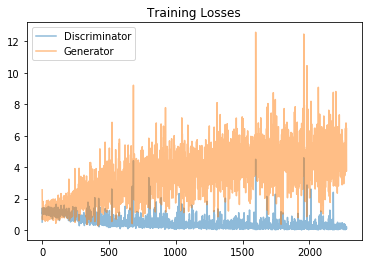

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0][1:], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1][1:], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

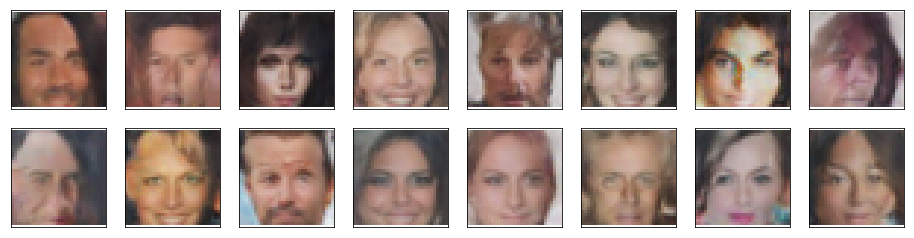

In [26]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** This dataset is biased towards almost perfect celebrity faces. This almost perfect faces mostly lack detailed textures. Therefore, the models trained on this dataset cannot generate faces with substantially fine-grained detail. To generate more realistic faces, we definitely need facial images of mass people with arguably much less perfection.

In almost all kinds of machine learning problems, careful incorporation of more sophisticated modeling components generally leads to better performance, which should logically be true for this task as well. Also, tuning the model and training hyperparameters should be done in the final stage of modeling. 

Also, more sophisticated GANs, such as Wasserstein or Relativistic GANs might be employed for better performance.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.